In [14]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from ml_algs.neural_nets.simple_net import SimpleNet

current_dir = %pwd

#### Prepare data

In [15]:
with open('./data/names.txt', 'r') as f:
    names = [line.strip() for line in f.readlines()]

In [16]:
x_str_to_int = {}
y_str_to_int = {}
all_chars = sorted(list(set('.abcdefghijklmnopqrstuvwxyz')))

new_idx = 0
for i, ch1 in enumerate(all_chars):
    y_str_to_int[ch1] = i
     
    for j, ch2 in enumerate(all_chars):        
        x_str_to_int[ch1+ch2] = new_idx
        new_idx += 1
        
x_int_to_char = {v: k for k, v in x_str_to_int.items()}
y_int_to_str = {v: k for k, v in y_str_to_int.items()}

In [17]:
xs_first, ys_first = [], []
xs_last, ys_last = [], []

for name in names:
    splitted = name.split(' ')
    first_name = ".." + splitted[0].lower() + "."
    last_name = ".." + splitted[1].lower() + "."

    for i in range(2, len(first_name)):
        xs_first.append(x_str_to_int[first_name[i-2:i]])
        ys_first.append(y_str_to_int[first_name[i]])

    for i in range(2, len(last_name)):
        xs_last.append(x_str_to_int[last_name[i-2:i]])
        ys_last.append(y_str_to_int[last_name[i]])

xs_first = torch.tensor(xs_first)
ys_first = torch.tensor(ys_first)
xs_last = torch.tensor(xs_last)
ys_last = torch.tensor(ys_last)

In [18]:
xs_first_train, x_tmp, ys_first_train, y_tmp = train_test_split(xs_first, ys_first, train_size=0.8)
xs_first_val, xs_first_test, ys_first_val, ys_first_test = train_test_split(x_tmp, y_tmp, test_size=0.5)

xs_last_train, x_tmp, ys_last_train, y_tmp = train_test_split(xs_last, ys_last, train_size=0.8)
xs_last_val, xs_last_test, ys_last_val, ys_last_test = train_test_split(x_tmp, y_tmp, test_size=0.5)

#### Train models

In [19]:
nnet_first = SimpleNet(
    input_len=len(x_str_to_int), 
    output_len=len(y_str_to_int), 
    learning_rate=30, 
    regularization_rate=0.01,
    random_seed=42
)

nnet_last = SimpleNet(
    input_len=len(x_str_to_int), 
    output_len=len(y_str_to_int), 
    learning_rate=30, 
    regularization_rate=0.01,
    random_seed=42
)

xenc_first_train = F.one_hot(xs_first_train, num_classes=len(x_str_to_int)).float()
xenc_last_train = F.one_hot(xs_last_train, num_classes=len(x_str_to_int)).float()

In [20]:
nnet_first.train(xenc_first_train, ys_first_train, n_epochs=20)

3.83666729927063
3.7247140407562256
3.5361509323120117
3.3347997665405273
3.14241886138916
2.9343130588531494
2.7626101970672607
2.624241828918457
2.4930031299591064
2.3880083560943604
2.318263292312622
2.2788045406341553
2.259702682495117
2.233811140060425
2.2256059646606445
2.2238340377807617
2.2107973098754883
2.206058979034424
2.2118990421295166
2.2073593139648438


In [21]:
nnet_last.train(xenc_last_train, ys_last_train, n_epochs=20)

3.831225633621216
3.728757381439209
3.552546739578247
3.3540918827056885
3.1847119331359863
3.0398929119110107
2.9096884727478027
2.786565065383911
2.664219856262207
2.56502366065979
2.500778913497925
2.474102735519409
2.455232620239258
2.4314849376678467
2.409336805343628
2.389409065246582
2.369590997695923
2.362075090408325
2.3809702396392822
2.3900184631347656


#### Evaluate loss

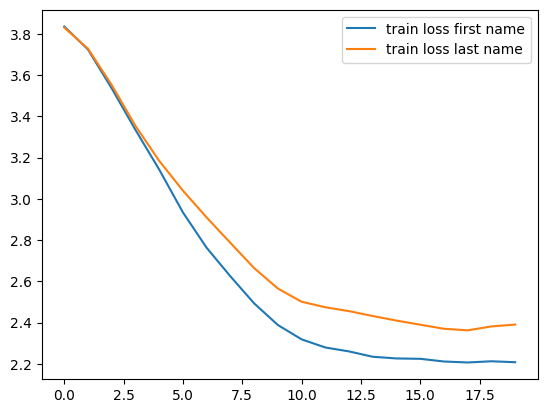

In [22]:
plt.plot(nnet_first.losses, label='train loss first name')
plt.plot(nnet_last.losses, label='train loss last name')
plt.legend()

In [23]:
g = torch.Generator().manual_seed(42)

xenc_first_val = F.one_hot(xs_first_val, num_classes=len(x_str_to_int)).float()
probs = nnet_first.eval(xenc_first_val)
loss_val = nnet_first.calculate_loss(probs, ys_first_val)

xenc_first_test = F.one_hot(xs_first_test, num_classes=len(x_str_to_int)).float()
probs = nnet_first.eval(xenc_first_test)
loss_test = nnet_first.calculate_loss(probs, ys_first_test)

print(loss_val)
print(loss_test)

tensor(2.2252, grad_fn=<AddBackward0>)
tensor(2.2179, grad_fn=<AddBackward0>)


In [24]:
g = torch.Generator().manual_seed(42)

xenc_last_val = F.one_hot(xs_last_val, num_classes=len(x_str_to_int)).float()
probs = nnet_last.eval(xenc_last_val)
loss_val = nnet_last.calculate_loss(probs, ys_last_val)

xenc_last_test = F.one_hot(xs_last_test, num_classes=len(x_str_to_int)).float()
probs = nnet_last.eval(xenc_last_test)
loss_test = nnet_last.calculate_loss(probs, ys_last_test)

print(loss_val)
print(loss_test)

tensor(2.3905, grad_fn=<AddBackward0>)
tensor(2.3789, grad_fn=<AddBackward0>)


#### Score model - generate new names

In [27]:
def generate_name(nnet, generator):
    x_str = ".."
    out = ""

    while True:
        x_int = x_str_to_int[x_str]
        xenc = F.one_hot(torch.tensor([x_int]), num_classes=len(x_str_to_int)).float()
        probs = nnet.eval(xenc)

        y_int = torch.multinomial(probs, num_samples=1, replacement=True, generator=generator).item()
        y_str = y_int_to_str[y_int]

        if y_str == ".":
            break

        x_str = x_str[1] + y_str
        out += y_str
    
    return out

In [28]:
g = torch.Generator().manual_seed(42)

for _ in range(20):
    first_name = generate_name(nnet_first, g)
    last_name = generate_name(nnet_last, g)
    
    print(f"{first_name} {last_name}")

kevid her
carony goner
jamatt th
cherine carker
hert aley
kel ster
jes reevander
gorgnxdzikllia ster
katt carricherrivzfjcqqfte
josephelline alens
rine han
davine ander
anne ster
th ell
kimberey an
eliel ander
ca ster
josephel alle
katt an
joshua jon
